In [11]:
import qaoa
import qucompsys as qucs
import graphs as gr
import qutip as qu
import numpy as np
import matplotlib.pyplot as plt
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
import networkx as nx
from   networkx.generators.random_graphs import erdos_renyi_graph
import configparser
import scipy
import itertools
from collections import Counter

import importlib
importlib.reload(qaoa)
importlib.reload(qucs)

%matplotlib inline
%config InlineBackened.figure_format = 'svg'

##  0 Define the graph

**method_1**: define manually graphs

In [2]:
#simple
n_nodes = 3
nodes = np.arange(0, n_nodes, 1)
edges = [(0,1),(1,2)]

In [12]:
#house
n_nodes = 5
nodes = np.arange(0, n_nodes, 1)
edges = [(0,1),(1,2),(1,4),(0,4),(2,3),(3,4)]

In [ ]:
#butterfly
n_nodes = 5
nodes = np.arange(0, n_nodes, 1)
edges = [(0,1),(0,2),(1,2),(2,3),(2,4),(3,4)]

In [135]:
# grid graph
n_nodes = 9
nodes = np.arange(0, n_nodes, 1)
edges = [(0, 1), (0,3), (1, 2), (1, 4), (2, 5), (3,4), (3,6), (4, 5), (4, 7), (5,8), (6, 7), (7, 8)]

In [136]:
n_qubits = n_nodes
graph = nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
edges = list(graph.edges)

**method_2**: generate random graph

### 0.1 plot the graph

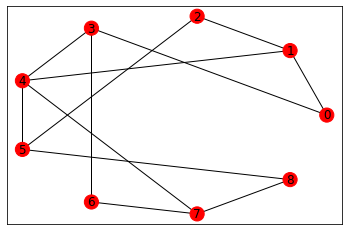

In [137]:
colors = ['r' for node in graph.nodes()]
pos = nx.circular_layout(graph)
graph_drawing = nx.draw_networkx(graph, node_color=colors, node_size=200, alpha=1, pos=pos, with_labels=True)
plt.show()

### 0.2 use grid serach for p=1

In [138]:
step_size = 0.01
a_gamma_mesh         = np.arange(-np.pi/2, np.pi/2, step_size) #see article with QAOA scheme for reference of this interval
a_beta_mesh          = np.arange(-np.pi/4, np.pi/4, step_size)
a_gamma_mesh, a_beta_mesh = np.meshgrid(a_gamma_mesh, a_beta_mesh, indexing='xy')
parameters_mesh = np.array([a_gamma_mesh, a_beta_mesh])

In [139]:
# Grid search for the maximizing variables
grid_F_1_mesh = qaoa.analitic_F_1(parameters_mesh, graph, edges)
result_mesh = np.where(grid_F_1_mesh == np.amax(grid_F_1_mesh))
max_pos_mesh      = list(zip(result_mesh[0],result_mesh[1]))[0]

In [140]:
optimal_gamma_mesh   = max_pos_mesh[1]*step_size
optimal_beta_mesh  = max_pos_mesh[0]*step_size

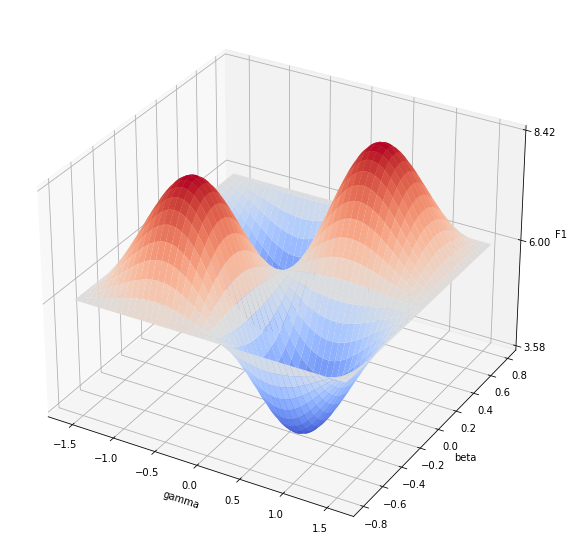


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  F_1 = 8.419
This is attained for gamma = 2.220 and beta = 1.180


In [141]:
# Plot the expetation value grid_f_1
fig = plt.figure(figsize = (10,10))
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(parameters_mesh[0], parameters_mesh[1], grid_F_1_mesh, cmap=cm.coolwarm, linewidth=0, antialiased=True)

#a_maximum_cut = find_maximum_cuts(n_qubits, edges)[0]
#max_cost_fun = qaoa.evaluate_cost_fun (a_maximum_cut, edges)
#ax.set_zlim(1,max_cost_fun)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_ylabel('beta')
ax.set_xlabel('gamma')
ax.set_zlabel('F1')

plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  F_1 = %.03f' % np.amax(grid_F_1_mesh))
#print('where the max_C is ', max_cost_fun)
print('This is attained for gamma = %.03f and beta = %.03f' % (optimal_gamma_mesh, optimal_beta_mesh))

In [21]:
optimal_params_scipy = scipy.optimize.minimize(qaoa.minus_analitic_F_1, [0.0, 0.0], args = (graph, edges), method='Nelder-Mead')['x']
optimal_gamma_scipy = optimal_params_scipy[0]
optimal_beta_scipy = optimal_params_scipy[1]

### 0.3 Define operators

In [153]:
I = qu.tensor([qu.qeye(2)]*n_qubits)
X = []
for i in range(n_qubits):
    X.append(qu.tensor([qu.qeye(2)]*i+[qu.sigmax()]+[qu.qeye(2)]*(n_qubits-i-1)))
Y = []
for i in range(n_qubits):
    Y.append(qu.tensor([qu.qeye(2)]*i+[qu.sigmay()]+[qu.qeye(2)]*(n_qubits-i-1)))
Z = []
for i in range(n_qubits):
    Z.append(qu.tensor([qu.qeye(2)]*i+[qu.sigmaz()]+[qu.qeye(2)]*(n_qubits-i-1)))
P_0 = []
for i in range(n_qubits):
    P_0.append(qu.tensor([qu.qeye(2)]*i+[qu.ket('0').proj()]+[qu.qeye(2)]*(n_qubits-i-1)))
P_1 = []
for i in range(n_qubits):
    P_1.append(qu.tensor([qu.qeye(2)]*i+[qu.ket('1').proj()]+[qu.qeye(2)]*(n_qubits-i-1)))

H_B = sum(X)
list_double_sigmaz = []
for edge in edges:
    list_double_sigmaz.append(Z[edge[0]]*Z[edge[1]])
H_P = 0.5*(len(edges)*qucs.n_qeye(n_qubits)-sum(list_double_sigmaz))
def evolution_operator(gammas, betas):
    evol_oper = I
    for i in range(len(gammas)):
        u_mix_hamilt_i = (-complex(0,betas[i])*H_B).expm()
        u_prob_hamilt_i = (-complex(0,gammas[i])*H_P).expm()
        evol_oper = u_mix_hamilt_i*u_prob_hamilt_i*evol_oper
    return evol_oper

In [49]:
float(abs(fin_state.dag()*P_0[1]*fin_state.full()))

0.49999999999999956

In [53]:
for i in range(n_qubits):
    print((fin_state.dag()*P_1[i]*fin_state).full())

[[0.5+0.j]]
[[0.5+0.j]]
[[0.5+0.j]]
[[0.5+0.j]]
[[0.5+0.j]]


In [54]:
for i in range(n_qubits):
    print((init_state.dag()*P_1[i]*init_state).full())

[[0.5+0.j]]
[[0.5+0.j]]
[[0.5+0.j]]
[[0.5+0.j]]
[[0.5+0.j]]


In [52]:
fin_state

Quantum object: dims = [[2, 2, 2, 2, 2], [1, 1, 1, 1, 1]], shape = (32, 1), type = ket
Qobj data =
[[ 0.05979253+0.04860579j]
 [-0.02163665+0.093993j  ]
 [ 0.08040059+0.02984937j]
 [-0.15664487+0.06321629j]
 [ 0.08040059+0.02984937j]
 [-0.14893968+0.28969475j]
 [-0.05460763-0.00092733j]
 [-0.10798678+0.03840152j]
 [-0.02163665+0.093993j  ]
 [-0.19385426+0.17785252j]
 [-0.14893968+0.28969475j]
 [-0.14519617+0.15303775j]
 [-0.15664487+0.06321629j]
 [-0.14519617+0.15303775j]
 [-0.10798678+0.03840152j]
 [ 0.03174251+0.05466414j]
 [ 0.03174251+0.05466414j]
 [-0.10798678+0.03840152j]
 [-0.14519617+0.15303775j]
 [-0.15664487+0.06321629j]
 [-0.14519617+0.15303775j]
 [-0.14893968+0.28969475j]
 [-0.19385426+0.17785252j]
 [-0.02163665+0.093993j  ]
 [-0.10798678+0.03840152j]
 [-0.05460763-0.00092733j]
 [-0.14893968+0.28969475j]
 [ 0.08040059+0.02984937j]
 [-0.15664487+0.06321629j]
 [ 0.08040059+0.02984937j]
 [-0.02163665+0.093993j  ]
 [ 0.05979253+0.04860579j]]

In [75]:
def single_qubit_measurement(qstate, qubit_pos):
    n_qubits = len(qstate.dims[0])
    M_i = P_0[qubit_pos]*qstate
    if qstate.dims[1][0] == 1:
        p0_i = float(abs((qstate.dag()*M_i).full()))
        if np.random.random_sample() <= p0_i:
            outcome = '0'
            qstate = M_i/np.sqrt(p0_i)
        else:
            outcome = '1'
            qstate = (P_1[qubit_pos]*qstate)/np.sqrt((1-p0_i))
    else:
        p0_i = M_i.tr()
        if np.random.random_sample() <= p0_i:
            outcome = '0'
            qstate = M_i/p0_i
        else:
            outcome = '1'
            qstate = (P_1[qubit_pos]*qstate)/(1-p0_i)
    return outcome, qstate

def quantum_measurements(n_samples, qstate):
    n_qubits = len(qstate.dims[0])
    outcomes = []
    for j in range(n_samples):
        outcome = ''
        qstate_dummy = qstate.copy()
        for i in range(n_qubits):
            outcome_i, qstate_dummy = single_qubit_measurement(qstate_dummy, i)
            outcome += outcome_i
        outcomes.append(outcome)
    return outcomes

## 1 Parameters optimization

## 1.1 Choose QAOA level and pick initial parameters

In [25]:
n_levels = 1

## 1.2 Generate initial state

${\large |s\rangle = \sum_{z \, \in \, \{0,1\}^n}^{}{|z\rangle} = |+\rangle^{\otimes n}}$

In [55]:
# initial state:
init_state = qaoa.initial_state(n_qubits)
dm_init_state = qu.ket2dm(qaoa.initial_state(n_qubits))

## 1.3 Obtain final state

${\large |\vec{\gamma},\vec{\beta}\rangle = U(B,\beta_p)U(C,\gamma_p)...U(B,\beta_1)U(C,\gamma_1)|s\rangle}$

In [103]:
# obtain final state:
#optimal_params = optimal_params_scipy
optimal_params = optimal_parameters_Adam_fin_diff
optimal_gammas = optimal_params[:n_levels]
optimal_betas = optimal_params[n_levels:]
fin_state = evolution_operator(optimal_gammas, optimal_betas)*init_state
dm_fin_state = evolution_operator(optimal_gammas, optimal_betas)*dm_init_state*evolution_operator(optimal_gammas, optimal_betas).dag()

In [38]:
fin_state

Quantum object: dims = [[2, 2, 2, 2, 2], [1, 1, 1, 1, 1]], shape = (32, 1), type = ket
Qobj data =
[[ 0.05979253+0.04860579j]
 [-0.02163665+0.093993j  ]
 [ 0.08040059+0.02984937j]
 [-0.15664487+0.06321629j]
 [ 0.08040059+0.02984937j]
 [-0.14893968+0.28969475j]
 [-0.05460763-0.00092733j]
 [-0.10798678+0.03840152j]
 [-0.02163665+0.093993j  ]
 [-0.19385426+0.17785252j]
 [-0.14893968+0.28969475j]
 [-0.14519617+0.15303775j]
 [-0.15664487+0.06321629j]
 [-0.14519617+0.15303775j]
 [-0.10798678+0.03840152j]
 [ 0.03174251+0.05466414j]
 [ 0.03174251+0.05466414j]
 [-0.10798678+0.03840152j]
 [-0.14519617+0.15303775j]
 [-0.15664487+0.06321629j]
 [-0.14519617+0.15303775j]
 [-0.14893968+0.28969475j]
 [-0.19385426+0.17785252j]
 [-0.02163665+0.093993j  ]
 [-0.10798678+0.03840152j]
 [-0.05460763-0.00092733j]
 [-0.14893968+0.28969475j]
 [ 0.08040059+0.02984937j]
 [-0.15664487+0.06321629j]
 [ 0.08040059+0.02984937j]
 [-0.02163665+0.093993j  ]
 [ 0.05979253+0.04860579j]]

##  1.4 Perform N-computational_basis measurements on $|\vec{\gamma},\vec{\beta}\rangle$ and evaluate $F_p$

In [151]:
def evaluate_F_p(params, n_qubits, edges, n_samples):
    gammas = params[:int(len(list(params))/2)]
    betas = params[int(len(list(params))/2):]
    
    # initial state:
    init_state = qaoa.initial_state(n_qubits)
    #obtain final state
    fin_state = evolution_operator(gammas, betas)*init_state
    
    #Perform N measurements on each single qubit of final state
    c_outcomes = Counter(quantum_measurements(n_samples, fin_state))
    
    #Evaluate Fp
    list_z = list(c_outcomes.keys())
    list_w = list(c_outcomes.values())
    Fp = 0
    for i in range(len(c_outcomes)):
        Fp += list_w[i]*qaoa.evaluate_cost_fun(list(list_z)[i], edges)
    return Fp/n_samples

In [152]:
qu.expect(H_P, fin_state)

2.654295634453291

In [105]:
n_samples = 10000
#optimal_params = optimal_params_scipy
optimal_params = optimal_parameters_Adam_fin_diff
F_p= evaluate_F_p(optimal_params, n_qubits, edges, n_samples)
F_p

4.7242

In [106]:
n_samples=10000
occurrencies = Counter(quantum_measurements(n_samples, fin_state))

<BarContainer object of 32 artists>

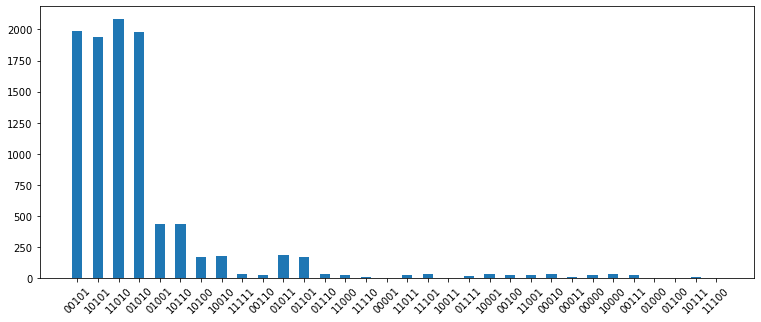

In [107]:
# plot probabilities of each state of the graph corresponding to every possible configuration after a cut
plt.figure(figsize = (2**n_qubits/2.5,5))
plt.xticks(rotation=45)
plt.bar(occurrencies.keys(),occurrencies.values(),width = 0.5)

In [116]:
def evaluate_F_p_j(params, n_qubits, index_j, edges, n_samples):
    gammas = params[:int(len(list(params))/2)]
    betas = params[int(len(list(params))/2):]
    edge = edges[index_j]
    
    # initial state (as density matrix):
    #dm_init_state = qu.ket2dm(initial_state(n_qubits))
    init_state = qaoa.initial_state(n_qubits)
    #obtain final state
    #dm_fin_state = evolution_operator(n_qubits, edges, gammas, betas)*dm_init_state*evolution_operator(n_qubits, edges, gammas, betas).dag()
    fin_state = evolution_operator(gammas, betas)*init_state
    
    #perform n_samples measurments on qubits in edge[0] and edge[1]
    outcomes = []
    for j in range(n_samples):
        outcome = ''
        qstate_dummy = fin_state.copy()
        for i in edge:
            outcome_i, qstate_dummy = single_qubit_measurement(qstate_dummy, i)
            outcome += outcome_i
        outcomes.append(outcome)
    c_outcomes = Counter(outcomes)
    
    #evaluate F_p_j
    list_z = list(c_outcomes.keys())
    list_w = list(c_outcomes.values())
    F_p_j = 0
    for i in range(len(list_w)):
        F_p_j += list_w[i]*qaoa.single_term_cost_fun(list(list_z)[i])
    return F_p_j/n_samples

### SGD: finite differences

In [154]:
#perform it for exp_F_1 (check if this method works properly for p=1 case)
n_steps = 20
n_levels=1
parameters = np.array(np.pi*np.random.random_sample(2*n_levels)) #check how choose initial params, for pi*rand is too dispersive
#parameters = 0.01*np.random.rand(2*n_levels)
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-8
m_t = np.zeros(2*n_levels)
v_t = np.zeros(2*n_levels)
t = 0
init_state = qaoa.initial_state(n_qubits)
eta = 0.05 #works also for eta = 0.01, but increases very slowly, and 0.1 oscillates too much around max
#previous_g_t = np.zeros(2*n_levels)
#H_P = qaoa.prob_hamilt(n_qubits, edges)
for i in range(n_steps):
    g_t = qaoa.fin_diff_grad(evaluate_F_p, parameters, args=(n_qubits, edges, 100), increment=0.1)
    gammas = parameters[:n_levels]
    betas = parameters[n_levels:]
    fin_state = evolution_operator(gammas, betas)*init_state
    F_p = qu.expect(H_P, fin_state)
    #if (i + 1) % 1 == 0:
    print('in', parameters, 'with grad ', g_t,  "objective after step {:5d}: {: .7f}".format(i + 1, F_p))
    t = t+1
    m_t = beta_1*m_t + (1-beta_1)*g_t
    v_t = beta_2*v_t + (1-beta_2)*g_t**2
    m_t_hat = m_t/(1-beta_1**t)
    v_t_hat = v_t/(1-beta_2**t)
    delta_params = eta*m_t_hat/(np.sqrt(v_t_hat) + epsilon)
    #if (np.sqrt(sum(delta_params**2)) < 0.02):
        #break
    parameters = parameters + delta_params
    #previous_g_t = g_t
optimal_parameters_Adam_fin_diff = parameters
print('optimal parameters are ', optimal_parameters_Adam_fin_diff, 'and F_p is', F_p)

in [2.23313842 1.07984599] with grad  [-0.25  0.6 ] objective after step     1:  6.2388927
in [2.18313843 1.12984599] with grad  [-1.35 -1.25] objective after step     2:  6.2797494
in [2.14045543 1.11079188] with grad  [ 1.  -0.1] objective after step     3:  6.2945867


KeyboardInterrupt: 

### doubly SGD

In [109]:
def doubly_stoc_grad_max_cut(params, n_qubits, edges, n_samples):
    d = len(list(params))
    a_params = np.array(params)
    g_t = np.zeros(d)
    m = len(edges)
    for i in range(d):
        
        #obtain indecies for the samplings
        index_j = np.random.randint(m)
        #index_r not necessary (they behave in the same way)
        #index_j' not necessary (they behave in the same way)
        index_k = np.random.randint(2)
        
        #obtain forward parameters
        e_i = np.zeros(d)
        e_i[i] = 1.0
        if index_k == 0:
            forward_params = a_params + np.pi*0.5*e_i
            epsilon_i = 0.5
        else:
            forward_params = a_params - np.pi*0.5*e_i
            epsilon_i = -0.5
            
        #obtain gradient estimator
        g_t[i] = evaluate_F_p_j(forward_params, n_qubits ,index_j, edges, n_samples)*epsilon_i*2*m
    return g_t

In [132]:
#Adam for doubly SGD
n_levels = 20 # paper found convergence for about 50 levels
n_steps = 100 # paper found convergence for about 10^4 steps
#parameters = 0.01*np.random.rand(2*n_levels)
parameters = np.array(np.pi*np.random.random_sample(2*n_levels)) #np.array(np.pi*np.random.random_sample(2*n_levels))
"""
parameters = np.zeros(2*n_levels) # method used in the paper
for j in range(2*n_levels):
    if j%2 == 0: #for H-p parameters
        parameters[j] = j/(2*n_levels) #see SGD paper for reference
    else:
        parameters[j] = 1 - j/(2*n_levels) #see SDG paper
"""
beta_1 = 0.8 # 0.8 in SGD paper
beta_2 = 0.999
epsilon = 1e-8
m_t = np.zeros(2*n_levels)
v_t = np.zeros(2*n_levels)
t = 0
eta = 0.001 # 0.001 in SDG paper
steps_vs_F_1 = []
init_state = qaoa.initial_state(n_qubits)
#previous_g_t = np.zeros(2*n_levels)
for i in range(n_steps): 
    g_t = doubly_stoc_grad_max_cut(parameters, n_qubits, edges, 1) # paper tried N = 1, 9, 81
    #if (np.sign(g_t) == -np.sign(previous_g_t)).all() and (np.sign(g_t) == -np.sign(np.ones(2*n_levels))).all():
        #break
    gammas = parameters[:n_levels]
    betas = parameters[n_levels:]
    fin_state = evolution_operator(gammas, betas)*init_state
    F_p = qu.expect(H_P, fin_state)
    #F_1 = qaoa.analitic_F_1(parameters, graph, edges)
    #if (i + 1) % 1001 == 0:
            #print('in', parameters, 'with grad ', g_t,  "objective after step {:5d}: {: .7f}".format(i + 1, F_1))
    t = t+1
    m_t = beta_1*m_t + (1-beta_1)*g_t
    v_t = beta_2*v_t + (1-beta_2)*g_t**2
    m_t_hat = m_t/(1-beta_1**t)
    v_t_hat = v_t/(1-beta_2**t)
    parameters = parameters + eta*m_t_hat/(np.sqrt(v_t_hat) + epsilon)
    #previous_g_t = g_t
    steps_vs_F_1.append([i+1]+[F_p])
optimal_parameters_Adam_doubly_stoc = parameters
print('optimal parameters are ', optimal_parameters_Adam_doubly_stoc,'with grad ', g_t, 'and F_1 is', qaoa.analitic_F_1(optimal_parameters_Adam_doubly_stoc, graph, edges))

optimal parameters are  [ 1.80705291  1.1968447   0.53439221  2.90510478  2.81750231  0.90885936
  0.41382598  2.29635581  0.03167685  0.43556785  2.18188126  1.18784249
  2.45839892  3.02577441  1.17506231  0.17357723  2.03393243  1.56453795
  2.06211063  1.24840611  0.78265394  2.24774785  2.40847057  2.36791732
 -0.0100395   0.03043904  0.90051315  2.06429405  1.46736072  2.24928436
  1.79741123  0.06475286  1.61155485  0.68024909  0.54460739  1.14799057
  1.3801574   1.58502439  0.28380919  1.52770098] with grad  [ 6.  0. -6.  6.  6.  0. -6.  0.  6. -0. -0.  6.  0.  0. -0.  0. -0. -6.
  0. -0. -0. -6. -6. -0. -6.  6. -6. -0.  0. -0. -6.  6.  0. -0.  6. -0.
 -0.  0. -6.  0.] and F_1 is 3.2607126930851025


In [133]:
steps = []
F_1 = []
for x_y in steps_vs_F_1:
    steps.append(x_y[0])
    F_1.append(x_y[1])

Text(0, 0.5, 'F_1')

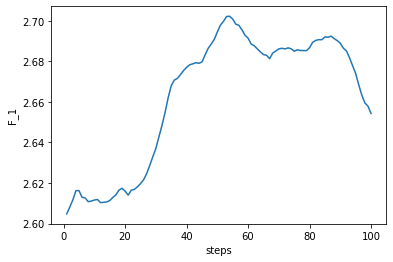

In [134]:
plt.plot(steps, F_1)
plt.xlabel('steps')
plt.ylabel('F_1')

In [160]:
#Adam
#perform it for exp_F_1 (check if this method works properly for p=1 case)
n_levels = 1
n_steps = 30
#parameters = np.array(np.pi/2*np.random.random_sample(2*n_levels)) #check how choose initial params, for pi*rand is too dispersive
#parameters = np.array(np.random.uniform(-np.pi/4, np.pi/4, 2*n_levels)) #check how choose initial params, for pi*rand is too dispersive
gammas = np.array(np.random.uniform(-np.pi/2, np.pi/2, n_levels))
betas = np.array(np.random.uniform(-np.pi/4, np.pi/4, n_levels))
parameters = np.array(list(gammas)+list(betas))
#parameters = 0.01*np.random.rand(2*n_levels)
init_state = qaoa.initial_state(n_qubits)
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-8
m_t = np.zeros(2*n_levels)
v_t = np.zeros(2*n_levels)
t = 0
adam_grad_fin_diff_g = []
adam_grad_fin_diff_b = []
adam_grad_fin_diff_F = []
eta = 0.05 #works also for eta = 0.01, but increases very slowly, and 0.1 oscillates too much around max
previous_g_t = np.zeros(2*n_levels)
for i in range(n_steps):
    g_t = qaoa.fin_diff_grad(evaluate_F_p, parameters, args=(n_qubits, edges, 100), increment=0.1)
    gammas = parameters[:n_levels]
    betas = parameters[n_levels:]
    fin_state = evolution_operator(gammas, betas)*init_state
    F_p_adam = qu.expect(H_P, fin_state)
    adam_grad_fin_diff_g.append(gammas[0])
    adam_grad_fin_diff_b.append(betas[0])
    adam_grad_fin_diff_F.append(F_p_adam)
    #if (np.sign(g_t) == -np.sign(previous_g_t)).all() and (np.sign(g_t) == -np.sign(np.ones(2*n_levels))).all():
        #break
    #if (i + 1) % 1 == 0:
    print('in', parameters, 'with grad ', g_t,  "objective after step {:5d}: {: .7f}".format(i + 1, F_p_adam))
    t = t+1
    m_t = beta_1*m_t + (1-beta_1)*g_t
    v_t = beta_2*v_t + (1-beta_2)*g_t**2
    m_t_hat = m_t/(1-beta_1**t)
    v_t_hat = v_t/(1-beta_2**t)
    parameters = parameters + eta*m_t_hat/(np.sqrt(v_t_hat) + epsilon)
    #previous_g_t = g_t
optimal_parameters_Adam_fin_diff = parameters
optimal_gammas = optimal_parameters_Adam_fin_diff[:n_levels]
optimal_betas = optimal_parameters_Adam_fin_diff[n_levels:]
print('optimal parameters are ', optimal_parameters_Adam_fin_diff, 'and F_1 is', qu.expect(H_P, evolution_operator(gammas, betas)*init_state))

in [ 1.3246175  -0.60993245] with grad  [ 2.45 -0.6 ] objective after step     1:  5.5741745
in [ 1.3746175  -0.65993245] with grad  [ 5.  -2.1] objective after step     2:  5.7587821
in [ 1.42276797 -0.70490877] with grad  [ 2.   -0.85] objective after step     3:  5.8862554
in [ 1.46859804 -0.74889598] with grad  [-2.75  1.9 ] objective after step     4:  5.9657960
in [ 1.4903772  -0.75856515] with grad  [-1.5  -0.05] objective after step     5:  5.9807216
in [ 1.50219713 -0.76718912] with grad  [ 1.85 -1.  ] objective after step     6:  5.9890004
in [ 1.51898033 -0.78246753] with grad  [-1.15  0.6 ] objective after step     7:  5.9986915
in [ 1.52929481 -0.79087313] with grad  [-0.8  0. ] objective after step     8:  6.0019301
in [ 1.53552321 -0.79828317] with grad  [-0.5 -1.8] objective after step     9:  6.0038257
in [ 1.53931304 -0.81593559] with grad  [-0.55 -2.35] objective after step    10:  6.0080330
in [ 1.54080865 -0.84223189] with grad  [-0.1  -1.75] objective after step  

In [162]:
step_size = 0.1
a_gamma_iter         = np.arange(-np.pi/2, np.pi/2, step_size)
a_beta_iter          = np.arange(-np.pi/4, np.pi/4, step_size)
grid_gammas_betas_iter = list(itertools.product(a_gamma_iter, a_beta_iter))
grid_F_1_iter = []
for par_iter in grid_gammas_betas_iter:
    fin_state = evolution_operator([par_iter[0]], [par_iter[1]])*init_state
    E_p = qu.expect(H_P, fin_state)
    grid_F_1_iter.append(E_p)

In [167]:
optimal_gamma_iter  = grid_gammas_betas_iter[grid_F_1_iter.index(max(grid_F_1_iter))][0]
optimal_beta_iter  = grid_gammas_betas_iter[grid_F_1_iter.index(max(grid_F_1_iter))][1]

In [169]:
%matplotlib qt
#%matplotlib inline
# Plot the expetation value grid_f_1
fig = plt.figure(figsize = (10,10))
ax  = fig.gca(projection='3d')


y_axis, x_axis = np.meshgrid(a_beta_iter, a_gamma_iter)
z_axis = np.reshape(np.array(grid_F_1_iter), y_axis.shape)

surf = ax.plot_surface(x_axis, y_axis, z_axis, cmap=cm.coolwarm, linewidth=0, antialiased=True, alpha=0.2)

#a_maximum_cut = find_maximum_cuts(n_qubits, edges)[0]
#max_cost_fun = qaoa.evaluate_cost_fun (a_maximum_cut, edges)
#max_cost_fun
#ax.set_zlim(1,max_cost_fun)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_ylabel('beta')
ax.set_xlabel('gamma')
ax.set_zlabel('F1')
ax.scatter(np.array(adam_grad_fin_diff_g), np.array(adam_grad_fin_diff_b), np.array(adam_grad_fin_diff_F), c=np.array(adam_grad_fin_diff_F), cmap='viridis', zorder=1);
#plt.scatter(np.array(adam_grad_fin_diff_g), np.array(adam_grad_fin_diff_b))
plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  F_1 = %.03f' % np.amax(z_axis))
#print('where the max_C is ', max_cost_fun)
print('This is attained for gamma = %.03f and beta = %.03f' % (optimal_gamma_iter, optimal_beta_iter))


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  F_1 = 8.416
This is attained for gamma = -0.671 and beta = -0.385
